# Widefield multi-color images with alternating illumination

In order to download the data, run the [download_data notebook](0_download_data.ipynb) first. 


In [1]:
import os
import os.path as op
import numpy as np
import tifffile as tff
import read_roi as rr
from skimage.metrics import mean_squared_error as mse

# define some matplotlib style for all figures
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
def read_image(path, norm = False):
    tif = tff.TiffFile(path)
    
    pages = []
    for page in tif.pages:
        array = page.asarray()
        if norm:
            array = array / np.max(array)
            
        pages.append(array)
        
    return np.array(pages)
        
def read_roi(path):
    return rr.read_roi_zip(path)

def extract_roi(roi):
    y0 = roi['left']
    x0 = roi['top']
    w = roi['width']
    h = roi['height']
    
    return x0, y0, w, h

def average_over_roi(img, roi, bg_subtraction = False):
    vals = np.zeros((img.shape[0],1))
    x0, y0, w, h = extract_roi(roi)
    
    for z in range(img.shape[0]):
        if bg_subtraction:
            vals[z] = np.mean(img[z, x0:x0+w, y0:y0+h])-np.mean(img[z,0:40,0:40])
        else:
            vals[z] = np.mean(img[z, x0:x0+w, y0:y0+h])
        
    return vals

def overlay_roi_im(img, roi, index = 0, value = 1):
    arr = np.copy(img[index,...])
    x0, y0, w, h = extract_roi(roi)
    
    for x in range(w+1):
        arr[x0+x,y0] = value
        arr[x0+x,y0+h] = value
        
    for y in range(h):
        arr[x0,y0+y] = value
        arr[x0+w,y0+y] = value
    
    return arr

def plot_frames(vals):
    n = len(vals)
    
    t = []
    rec = []
    for i in range(n):
        t.append(i)
        t.append(i+1)
        rec.append(vals[i])
        rec.append(vals[i])
    
    plt.figure()
    plt.plot(t, rec, '-')
    
def split_pattern(vals, pattern):
    np_indices = []
    split = []
    filt = [s == '1' for s in pattern]
    
    n = len(filt)
    m = len(vals)
    
    quo = m//n
    for i in range(quo):
        ind = np.where(filt)
        filtered = vals[i*n:(i+1)*n][ind]
        
        split.append(filtered)
        np_indices.append(ind)
        
    rem = m%n
    if not rem == 0:
        ind = np.where(filt[:rem])
        filtered = vals[quo*n:][np.where(filt[:rem])]
        
        split.append(filtered)
        np_indices.append(ind)
        
    indices = []
    for i, ind in enumerate(np_indices):
        indices.extend((i*n+ind[0]).tolist())
        
    return np.concatenate(split, axis = 0), indices
    
def plot_overlays_intensity(img, rois, offset = 0, patterns = [], bg_subtraction = False):
    for i, k in enumerate(rois.keys()):

        plt.figure(figsize=(15, 15))
        for j in range(len(rois.keys())):
            plt.subplot(1, len(rois.keys()), j+1)
            plt.imshow(overlay_roi_im(img, rois[k], offset+j))

        av = average_over_roi(img, rois[k], bg_subtraction)
        
        if len(patterns) == 0:
            plt.figure()
            plt.plot([i for i in range(av.shape[0])], av, '.')
        else:
            plt.figure()
            for p in patterns:
                a_filt, ind = split_pattern(av[offset:], p)
                plt.plot(ind, a_filt, '.')
                
def plot_pattern_mse(img, index = [], pattern = None, data_range = 65535):
    
    if index:
        
        fig, axs = plt.subplots(1, len(index), sharey=True)
        for k, ind in enumerate(index):
            ref = img[ind,...]
            if pattern:
                for i, p in enumerate(pattern):
                    mse_p = []
                    inds_p = []
                    for z in range(img.shape[0]):
                        if z != ind and p[z%16] == '1':
                            v_mse = mse(ref, img[z,...])
                            mse_p.append(v_mse)
                            inds_p.append(z)

                    axs[k].plot(inds_p, mse_p, '.')
                    axs[k].title.set_text(f'Frame {ind}')
                    axs[k].set_xlabel('frame')
                    if k==0:
                        axs[k].set_ylabel('mse (a.u.)')
        


## Multi-color with interleaved excitation


In [3]:
root = op.join('data','M3_multi-color_interleaved')
folder = '21_Sample4_Nup96-646_Tub-488_Tom20-CF568_488i1p500_561i1p4k_640i1_quadfilter-only_x25_1'
file = '21_Sample4_Nup96-646_Tub-488_Tom20-CF568_488i1p500_561i1p4k_640i1_quadfilter-only_x25_1_MMStack_Pos0.ome.tif'

    
f = op.join(root,folder,file)
im = read_image(f)
print(im.shape)

(200, 239, 239)


In [4]:
file = 'RoiSet_21.zip'

rois = read_roi(op.join(root,file))
print(rois)

OrderedDict([('0005-0119-0111', {'type': 'rectangle', 'left': 103, 'top': 111, 'width': 17, 'height': 17, 'arc_size': 0, 'name': '0005-0119-0111', 'position': 5}), ('0007-0159-0134', {'type': 'rectangle', 'left': 126, 'top': 151, 'width': 17, 'height': 17, 'arc_size': 0, 'name': '0007-0159-0134', 'position': 7}), ('0015-0157-0162', {'type': 'rectangle', 'left': 154, 'top': 149, 'width': 17, 'height': 17, 'arc_size': 0, 'name': '0015-0157-0162', 'position': 15})])


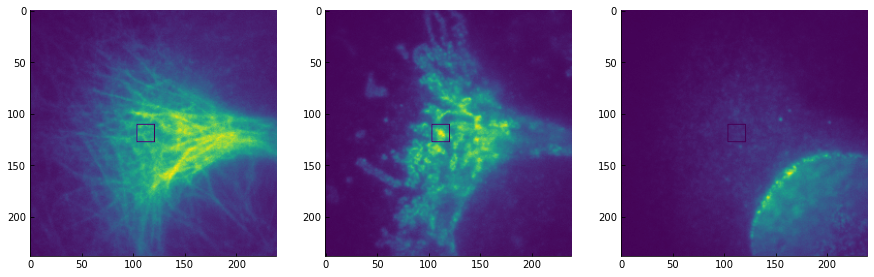

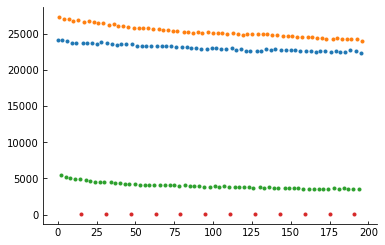

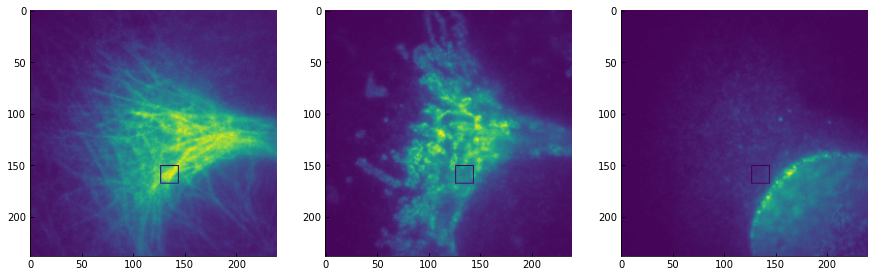

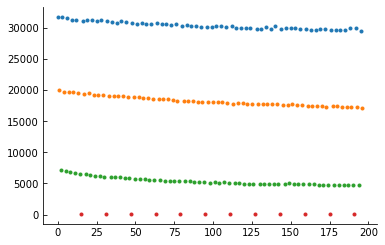

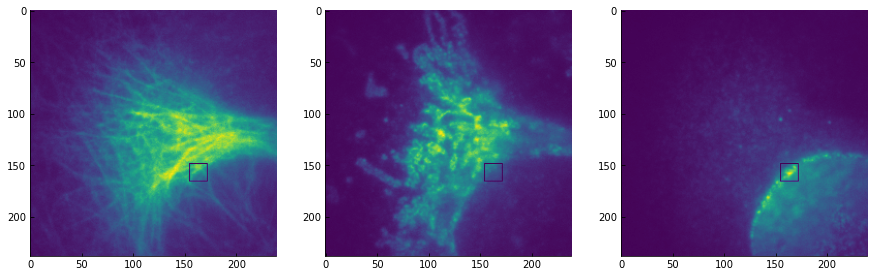

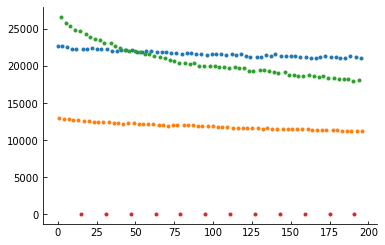

In [5]:
patterns = ['1001001001001000','0100100100100100','0010010010010010','0000000000000001']
plot_overlays_intensity(im[3:,...], rois, patterns = patterns, bg_subtraction=True)

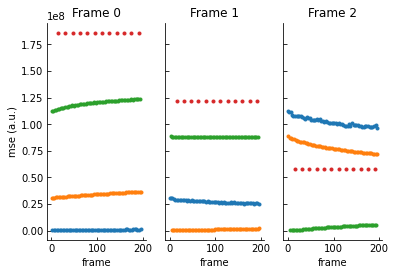

In [6]:
plot_pattern_mse(im[3:,...], index = [0, 1, 2], pattern=patterns)

dir_path = 'figs'
if not os.path.isdir(dir_path): os.mkdir(dir_path)
plt.savefig(op.join(dir_path,'fig_3C_interleaved.eps'), format='eps')

In [7]:
root = op.join('all_data','211210_PH_xPH007_multi-color_interleaved_cont')
folder = '41_Sample4_DAPI_Nup96-646_Tub-488_Tom20-CF568_405i1p3k_488i1p250_561i1p2k_640i1p11k_quadfilter-only_x25_1'
file = '41_Sample4_DAPI_Nup96-646_Tub-488_Tom20-CF568_405i1p3k_488i1p250_561i1p2k_640i1p11k_quadfilter-only_x25_1_MMStack_Pos0.ome.tif'

    
f = op.join(root,folder,file)
im = read_image(f, True)
print(im.shape)

(200, 239, 239)


In [8]:
file = op.join(root,'41_1/RoiSet.zip')

rois = read_roi(file)
print(rois)

OrderedDict([('Tom20', {'type': 'rectangle', 'left': 192, 'top': 116, 'width': 13, 'height': 13, 'arc_size': 0, 'name': 'Tom20', 'position': 3}), ('Nup', {'type': 'rectangle', 'left': 95, 'top': 115, 'width': 13, 'height': 13, 'arc_size': 0, 'name': 'Nup', 'position': 4}), ('DAPI', {'type': 'rectangle', 'left': 123, 'top': 116, 'width': 13, 'height': 13, 'arc_size': 0, 'name': 'DAPI', 'position': 1}), ('MT', {'type': 'rectangle', 'left': 152, 'top': 96, 'width': 13, 'height': 13, 'arc_size': 0, 'name': 'MT', 'position': 2})])


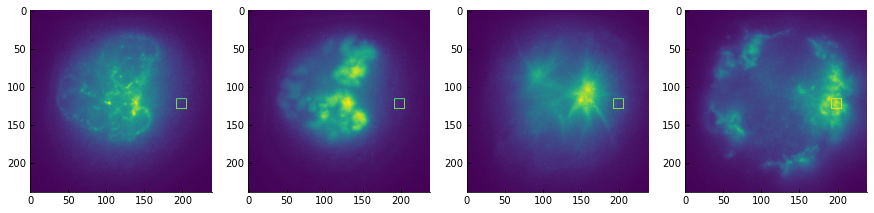

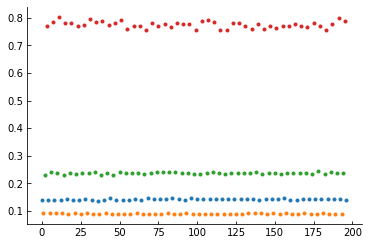

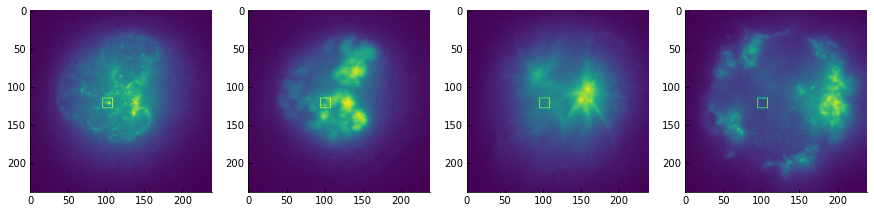

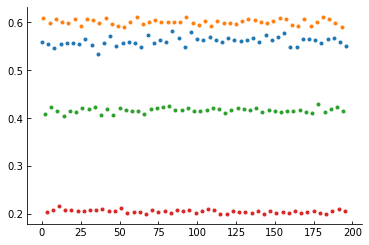

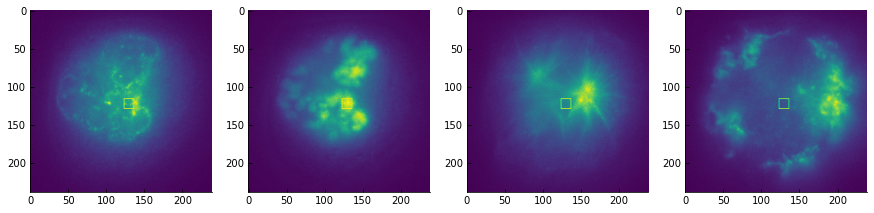

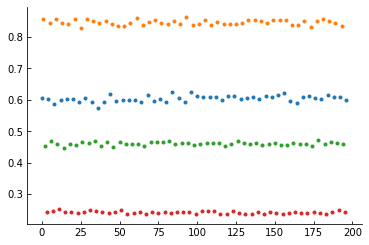

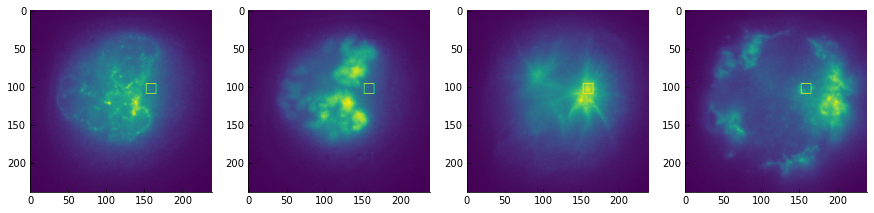

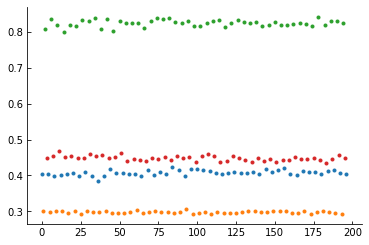

In [9]:
patterns = ['1000100010001000','0100010001000100','0010001000100010','0001000100010001']
plot_overlays_intensity(im[3:,...], rois, patterns = patterns, bg_subtraction = True)

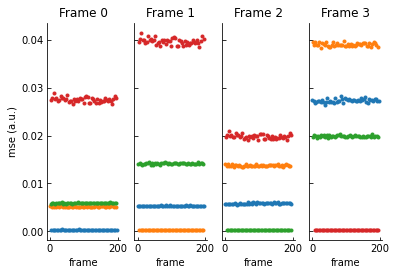

In [10]:
plot_pattern_mse(im[3:,...], index = [0,1,2,3], pattern=patterns)

dir_path = 'figs'
if not os.path.isdir(dir_path): os.mkdir(dir_path)
plt.savefig(op.join(dir_path,'fig_4C_interleaved.eps'), format='eps')